# Histopathologic Cancer Detection using Deep Learning

### 0. Importamos las librerias necesarias para el analisis de las imágenes y la realización de las predicciones

In [1]:
import numpy as np 
import pandas as pd
from glob import glob 
from skimage.io import imread
import os
import matplotlib.pyplot as plt
import shutil
import keras.backend as K

Using TensorFlow backend.


## 1. Preprocesamiento de los datos

### 1.1 Armamos el dataframe con el conjunto de datos de entrenamiento

In [2]:
train_dir = '../iis-project/train'
df = pd.DataFrame({'path': glob(os.path.join(train_dir,'*.tif'))})
labels = pd.read_csv("../iis-project/train_labels.csv")
df['label'] = labels['label']
df.head(10)



,path,label
0,../iis-project/train/052fddb3940ec9f4b9d7d0925...,0
1,../iis-project/train/70e728f78f937dfb16e9867e8...,1
2,../iis-project/train/9b59ba4f1bb5ea63828450fdc...,0
3,../iis-project/train/e0dfb12d1e7116ffa26b7a967...,0
4,../iis-project/train/ea62cbcd62f4438f47902b1bf...,0
5,../iis-project/train/cc5be12926073b97cb9d5146e...,0
6,../iis-project/train/5bf198b5f0732515d0d402a85...,1
7,../iis-project/train/09e441c22952ad49a8a4acb81...,1
8,../iis-project/train/6dfe8a3ca29bff5a2bb108ec2...,0
9,../iis-project/train/7e4b77f241ef3d8d21b188b75...,0


### 1.2 Se selecciona una muestra de cada etiqueta

           
    Se crean 2 dataframes, uno para cada etiqueta, cada uno de ellos con 10000 elementos ya que tomar en cuenta todo el conjunto no resulta práctico por las limitaciones de recursos fisicos como memoria RAM y/o disco. A partir de estos dataframes se crea uno nuevo que contenga el conjunto de datos reducido.

In [46]:
sample_label0 = df[df.label == 0].sample(1000, random_state=42)
sample_label1 = df[df.label == 1].sample(1000, random_state=42)


reduced_df = pd.DataFrame(pd.concat([sample_label0, sample_label1]))
reduced_df

,path,label
121450,../iis-project/train/4673be499941f9f90534c9281...,0
38268,../iis-project/train/6131dbeccea55a3e636cf92b7...,0
158080,../iis-project/train/9fb2f3b06d0d4663a65c675a3...,0
154803,../iis-project/train/0ed4f3238f6bdedc752166442...,0
93791,../iis-project/train/81baf1c16cbbf278fe40781ff...,0
60871,../iis-project/train/9f37f9a365eb1a4e08865c092...,0
161998,../iis-project/train/623a95c429c2c5e1650763577...,0
123660,../iis-project/train/1083aec88d68e5efbedbbaea2...,0
42891,../iis-project/train/5558da01187c1e22894b228d8...,0
59004,../iis-project/train/b9fef2b74b5a7386c80bf7808...,0


In [47]:
directory_1 = "../iis-project/red_train"
directory_2 = "../iis-project/red_validation"

shutil.rmtree(directory_1)
shutil.rmtree(directory_2)

if not os.path.exists(directory_1):
    os.makedirs(directory_1)
if not os.path.exists(directory_2):
    os.makedirs(directory_2)

for folder in [directory_1, directory_2]:
    for subfolder in ['0', '1']:
        path = os.path.join(folder, subfolder)
        os.makedirs(path, exist_ok=True)

In [48]:
from sklearn.model_selection import train_test_split

#Stratifying data into train and validation with label 0
X_train0, X_val0, y_train0, y_val0 = train_test_split(
        sample_label0['path'],sample_label0['label'], test_size=0.2, random_state=42)

#Stratifying data into train and validation with label 1
X_train1, X_val1, y_train1, y_val1 = train_test_split(
        sample_label1['path'],sample_label1['label'], test_size=0.2, random_state=42)


lt0 = X_train0.tolist()
lt1 = X_train1.tolist()
lv0 = X_val0.tolist()
lv1 = X_val1.tolist()
for files in lt0:
    shutil.copy(files, os.path.join(directory_1,'0'))
for files in lt1:
    shutil.copy(files, os.path.join(directory_1,'1'))
for files in lv0:
    shutil.copy(files, os.path.join(directory_2,'0'))
for files in lv1:
    shutil.copy(files, os.path.join(directory_2,'1'))



### 1.3 Data augmentation

In [49]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)


## 2. Comparación de modelos

## 2.1 Modelo particular

### 2.1.1 Entrenamos el modelo

In [ ]:
from keras.models import Sequential 
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Activation
import math

img_width, img_height = 32, 32
BATCH_SIZE = 16

model_1 = Sequential()
model_1.add(Conv2D(32, 3, 3, input_shape = (32,32, 3)))
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D(2, 2))

model_1.add(Conv2D(32, 3, 3))
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D(2, 2))

model_1.add(Conv2D(64, 3, 3))
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D(2, 2))

model_1.add(Flatten())

model_1.add(Dense(128))
model_1.add(Activation('relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(1, activation='sigmoid'))

model_1.compile(optimizer='sgd',
              loss='binary_crossentropy', metrics=['accuracy'])


train_generator = train_datagen.flow_from_directory(
        directory_1,
        target_size=(32,32),
        batch_size=32,
        class_mode='binary')

validation_generator = val_datagen.flow_from_directory(
        directory_2,
        target_size=(32,32),
        batch_size=32,
        class_mode='binary')

history = model_1.fit_generator(
                train_generator,
                #steps_per_epoch=(len(lt0) + len(lt1)),
                steps_per_epoch=math.floor((len(lt0) + len(lt1)) / BATCH_SIZE),
                epochs=10,
                validation_data=validation_generator,
                #validation_steps=((len(lv0) + len(lv1))))
                validation_steps=((len(lv0) + len(lv1))) / BATCH_SIZE)


In [ ]:
model_1.summary()

### 2.1.2 Generamos las graficas con las medidas de desempeño

In [ ]:
# Training plots
epochs = [i for i in range(1, len(history.history['loss'])+1)]

plt.plot(epochs, history.history['loss'], color='green', label="training_loss")
plt.plot(epochs, history.history['val_loss'], color='orange', label="validation_loss")
plt.legend(loc='best')
plt.title('training')
plt.xlabel('epoch')
plt.show()
plt.close()

plt.plot(epochs, history.history['acc'], color='green', label="training_accuracy")
plt.plot(epochs, history.history['val_acc'], color='orange',label="validation_accuracy")
plt.legend(loc='best')
plt.title('validation')
plt.xlabel('epoch')
plt.show()
plt.close()

### 2.1.3 Creamos el archivo csv con las predicciones

### 2.1.4 Obtenemos el area bajo la curva ROC

## 2.2 Modelo Pre-entrenado

In [51]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications

# dimensions of our images.
img_width, img_height = 96, 96

top_model_weights_path = 'bottleneck_fc_model.h5'
train_data_dir = '../iis-project/red_train'
validation_data_dir = '../iis-project/red_validation'
nb_train_samples = len(lt0) + len(lt1)
nb_validation_samples = len(lv0) + len(lv1)
epochs = 50
batch_size = 16

datagen = ImageDataGenerator(rescale=1. / 255)

# build the MobileNet network
model = applications.InceptionV3(include_top=False, weights='imagenet', input_shape=(img_width, img_height, 3))
#model = applications.Xception(include_top=False, weights='imagenet', input_shape=(img_width, img_height, 3))
tgen = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

bottleneck_features_train = model.predict_generator(
    tgen, nb_train_samples // batch_size)

np.save('bottleneck_features_train.npy',
        bottleneck_features_train)

vgen = val_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)
bottleneck_features_validation = model.predict_generator(
    vgen, nb_validation_samples // batch_size)
np.save('bottleneck_features_validation.npy',
        bottleneck_features_validation)

Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [52]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
conv2d_302 (Conv2D)             (None, 47, 47, 32)   864         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_295 (BatchN (None, 47, 47, 32)   96          conv2d_302[0][0]                 
__________________________________________________________________________________________________
activation_287 (Activation)     (None, 47, 47, 32)   0           batch_normalization_295[0][0]    
__________________________________________________________________________________________________
conv2d_303

In [53]:
train_data = np.load('bottleneck_features_train.npy')
train_labels = np.array(
    [0] * int(nb_train_samples / 2) + [1] * int(nb_train_samples / 2))

validation_data = np.load('bottleneck_features_validation.npy')
validation_labels = np.array(
    [0] * int(nb_validation_samples / 2) + [1] * int(nb_validation_samples / 2))

model_1 = Sequential()
model_1.add(Flatten(input_shape=train_data.shape[1:]))
model_1.add(Dense(256, activation='relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(1, activation='sigmoid'))

model_1.compile(optimizer='rmsprop',
              loss='binary_crossentropy', metrics=['accuracy'])

h = model_1.fit(train_data, train_labels,
          epochs=10,
          batch_size=batch_size,
          validation_data=(validation_data, validation_labels))
model_1.save_weights(top_model_weights_path)

Train on 1600 samples, validate on 400 samples
Epoch 1/10
1600/1600 [==============================] - 16s 10ms/step - loss: 1.0741 - acc: 0.5144 - val_loss: 0.8017 - val_acc: 0.4975
Epoch 2/10
1600/1600 [==============================] - 2s 1ms/step - loss: 0.7382 - acc: 0.5413 - val_loss: 0.7384 - val_acc: 0.4725
Epoch 3/10
1600/1600 [==============================] - 2s 1ms/step - loss: 0.7107 - acc: 0.5713 - val_loss: 0.7560 - val_acc: 0.4800
Epoch 4/10
1600/1600 [==============================] - 2s 1ms/step - loss: 0.6942 - acc: 0.5931 - val_loss: 0.7537 - val_acc: 0.4850
Epoch 5/10
1600/1600 [==============================] - 2s 1ms/step - loss: 0.6612 - acc: 0.6225 - val_loss: 0.7842 - val_acc: 0.4675
Epoch 6/10
1600/1600 [==============================] - 2s 1ms/step - loss: 0.6397 - acc: 0.6506 - val_loss: 0.8137 - val_acc: 0.5125
Epoch 7/10
1600/1600 [==============================] - 2s 1ms/step - loss: 0.5958 - acc: 0.6750 - val_loss: 0.8462 - val_acc: 0.4650
Epoch 8/10
16

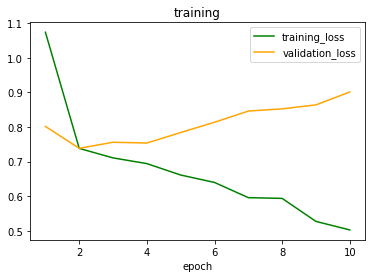

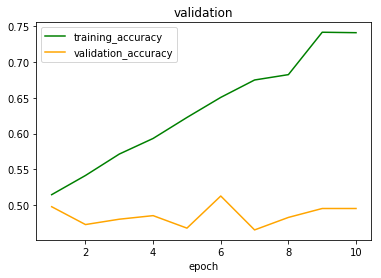

In [54]:
# Training plots
epochs = [i for i in range(1, len(h.history['loss'])+1)]

plt.plot(epochs, h.history['loss'], color='green', label="training_loss")
plt.plot(epochs, h.history['val_loss'], color='orange', label="validation_loss")
plt.legend(loc='best')
plt.title('training')
plt.xlabel('epoch')
plt.show()
plt.close()

plt.plot(epochs, h.history['acc'], color='green', label="training_accuracy")
plt.plot(epochs, h.history['val_acc'], color='orange',label="validation_accuracy")
plt.legend(loc='best')
plt.title('validation')
plt.xlabel('epoch')
plt.show()
plt.close()